In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import pathlib
import random

# Reading the data

In [13]:
pepper_dataset = "/kaggle/input/plantdisease/PlantVillage"
pepper_dataset

'/kaggle/input/plantdisease/PlantVillage'

In [14]:
class_names = ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [15]:
IMG_SIZE = 256
BATCH_SIZE=32

In [16]:
pepper_dataset = tf.keras.utils.image_dataset_from_directory(
    pepper_dataset,
    seed=12,
    labels="inferred", # Labels from subfolders (e.g., "cat", "dog")
    image_size=(IMG_SIZE,IMG_SIZE),   # Resize images
    batch_size=BATCH_SIZE,
    class_names = class_names,
    shuffle=True
)

Found 2475 files belonging to 2 classes.


In [17]:
pepper_dataset.class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

# Visualizing the data

In [18]:
# function ==> take(1) returns the first batch consists of 32 images
for image_batch, labels_batch in pepper_dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 1 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 0 0 0 1 0 1 0 1 0 1 1 0 0 0]


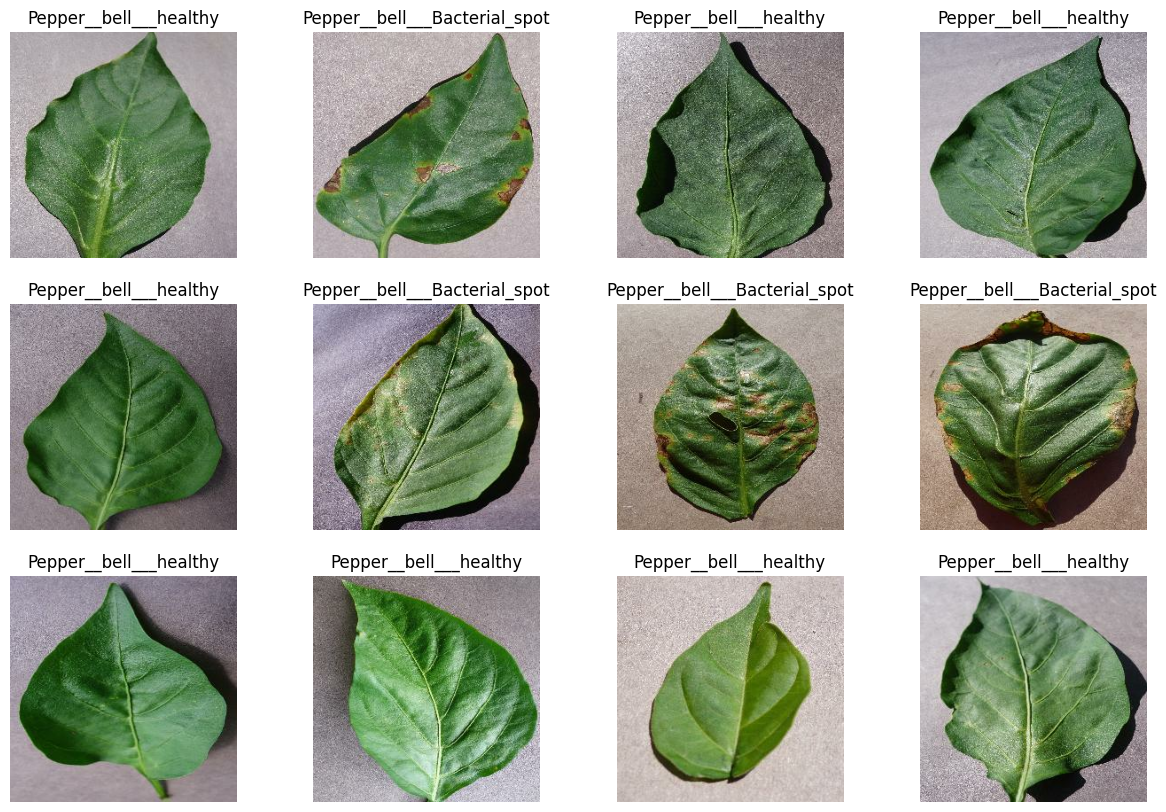

In [19]:
plt.figure(figsize=(15, 10))
for image_batch, labels_batch in pepper_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Function to split dataset
Training: Dataset to be used while training

Validation: Dataset to be tested against while training

Test: Dataset to be tested against after we trained a model

In [20]:
print("Number of batches =",len(pepper_dataset))

Number of batches = 78


80% train 

10% validation

10% test

In [22]:
def get_dataset_partitions_tf(ds, train_part=0.8, validation_part=0.1, test_part=0.1, shuffle=True, shuffle_size=10000):
    assert (train_part + test_part + validation_part) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_part * ds_size)
    val_size = int(validation_part * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [23]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(pepper_dataset)

In [24]:
print("Number of training batches is",len(train_ds))
print("Number of validation batches is",len(val_ds))
print("Number of testing batches is",len(test_ds))

Number of training batches is 62
Number of validation batches is 7
Number of testing batches is 9


# Cache 
Speeds up training when you have preprocessing steps

Essential when using data augmentation to prevent re-applying random transforms

# Shuffle
Prevents the model from learning artificial patterns from data order

# Prefetch

Eliminates GPU idle time between batches

Can improve training speed by 20-30%

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the model 

# resizing and rescaling layer

In [26]:
# Normalizing the image to range from 0 ==> 1 by dividing by 255
resizing_rescaling = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),  
    layers.Rescaling(1./255),                 
])

# Data augmentation

In [27]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

# The model 

In [41]:
input_shape = (IMG_SIZE,IMG_SIZE,3) # 3 is the number of channels (RGB)
model = models.Sequential([
    layers.Input(shape=input_shape),  # Add this explicitly
    resizing_rescaling,
    data_augmentation,
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')
])


In [42]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 254, 254, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 127, 127, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 125, 125, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297,154 (1.13 MB)

 Trainable params: 297,154 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),optimizer = 'adam',
             metrics = ['accuracy'])

In [45]:
model.fit(
    train_ds,
    epochs = 50,
    verbose = 1,
    validation_data = val_ds,
    batch_size = BATCH_SIZE
)

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 215s 3s/step - accuracy: 0.6075 - loss: 0.6743 - val_accuracy: 0.7589 - val_loss: 0.5261
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.8695 - loss: 0.3719 - val_accuracy: 0.7411 - val_loss: 0.4596
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - accuracy: 0.9263 - loss: 0.2125 - val_accuracy: 0.8884 - val_loss: 0.2441
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.9730 - loss: 0.1029 - val_accuracy: 0.9241 - val_loss: 0.1806
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.9887 - loss: 0.0556 - val_accuracy: 0.9821 - val_loss: 0.0522
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step - accuracy: 0.9897 - loss: 0.0481 - val_accuracy: 0.9955 - val_loss: 0.0315
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.9914 - loss: 0.0397 - val_accuracy: 0.9866 - val_loss: 0.0536
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.9838 - loss: 0.0628 - val_accuracy: 0.9911 - v

In [46]:
model.evaluate(test_ds)

9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 892ms/step - accuracy: 0.9816 - loss: 0.0165


[0.00682384567335248, 0.9930555820465088]

# Predictions

Image to predict :
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step
Actual label: Pepper__bell___healthy
Predicted label: Pepper__bell___healthy


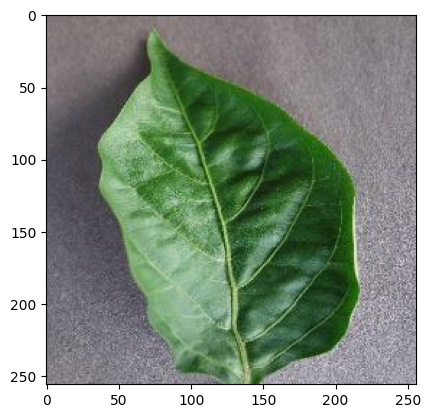

In [50]:
for image_batch, labels_batch in test_ds.take(1):
    image = image_batch[0].numpy().astype('uint8')
    label = labels_batch[0].numpy()
    print('Image to predict :')
    plt.imshow(image)
    
    prediction = model.predict(image_batch)
    print('Actual label:',class_names[label])
    print('Predicted label:',class_names[np.argmax(prediction[0])])

In [53]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * np.max(prediction[0]),2)
    return predicted_class,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


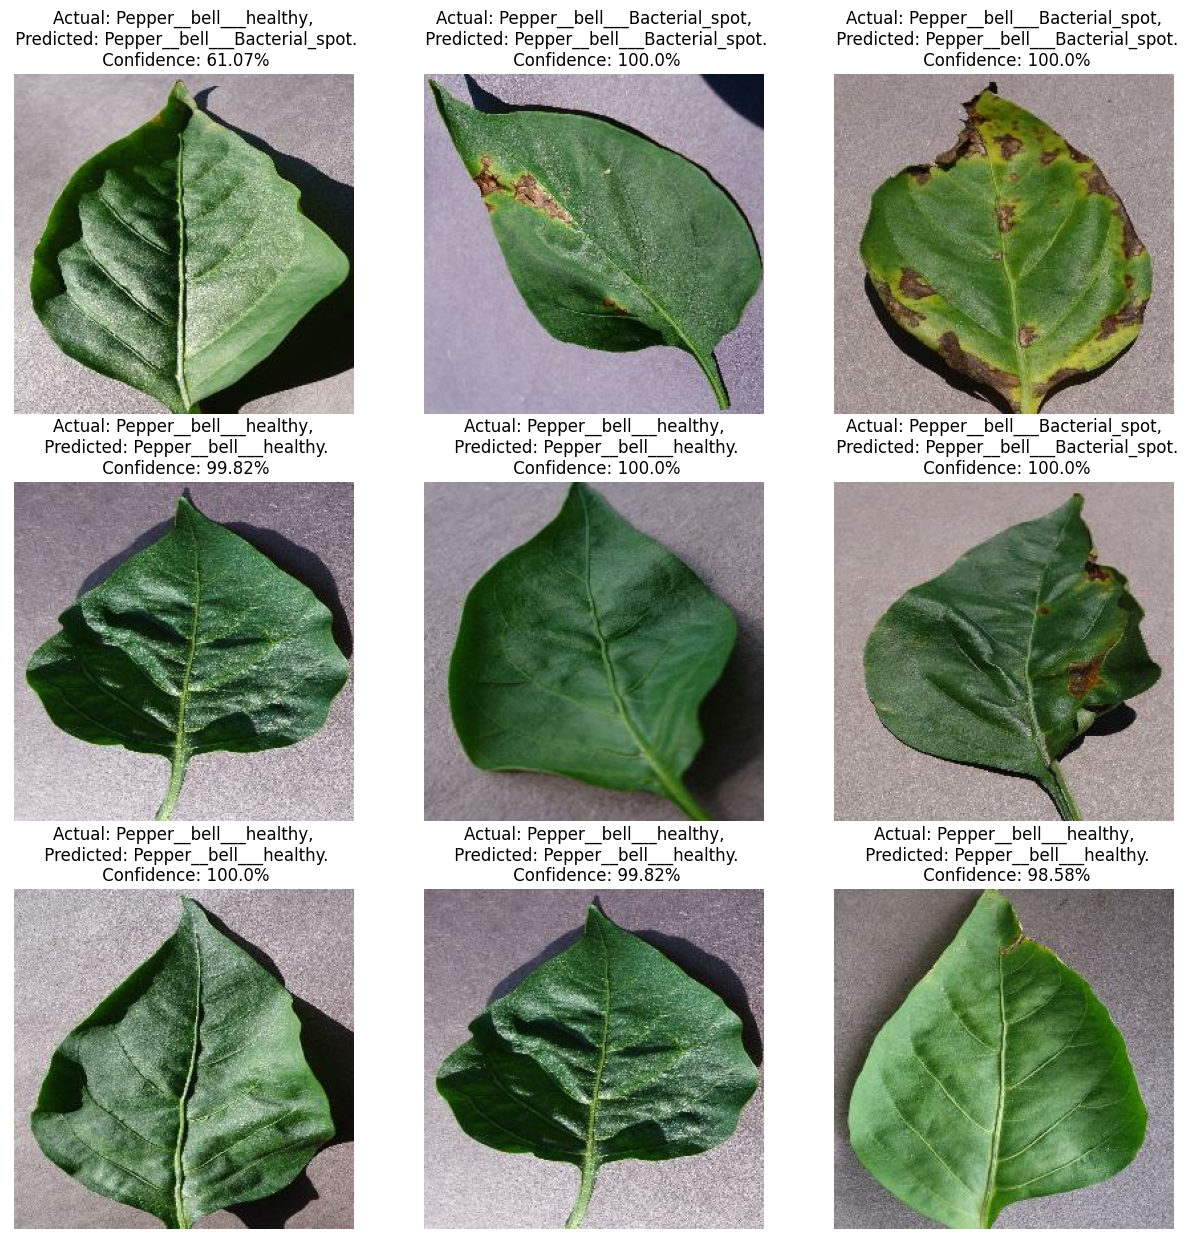

In [58]:
import random
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        idx = random.randint(0, len(images) - 1)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[idx].numpy().astype("uint8"))
        predicted_class,confidence = predict(model,images[idx].numpy())
        actual_class = class_names[labels[idx]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")